In [40]:
%matplotlib notebook
import csv
import pandas as pd
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
from pandas.io.parsers import read_csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

In [41]:
def load_data(filename):
    data = pd.read_csv(filename, header=None, delimiter=',').values
    attrnum = data.shape[1]-1
    return data[:, :attrnum], data[:, attrnum]

In [42]:
data, y = load_data('car.csv')

In [43]:
y, label = pd.factorize(y)
for i in range(data.shape[1]):
    data[:,i], labels= pd.factorize(data[:,i])

In [44]:
data = data.astype('float64')
y = y.astype('float64')
y = y.reshape(1728,1)
y.shape

(1728, 1)

In [45]:
unos = np.full((1728,1),1)
th =np.zeros((7,1))
x = np.append(unos.astype('float64'), data, axis=1)

Utilizando el metodo de oneVsAll (practica 3, primera parte)

In [46]:
def sigmoide(z):
    s = np.dot(z,-1)
    e = np.exp(s)
    d = 1 + e
    return 1/d

In [47]:
def coste(th, x, y, lamda=1):
    g = sigmoide(np.dot(x,th))
    log1 = np.log(g)
    log2 = np.log(1-g)
    tr1 = np.dot(np.transpose(log1),y)
    tr2 = np.dot(np.transpose(log2),(1-y))
    c = -(tr1+tr2)/len(y)
    s = np.sum(th**2)/(2*len(y))
    return c + lamda*s

In [48]:
def gradiente(th,x,y,lamda=1):
    return np.dot(np.transpose(x),sigmoide(np.dot(x,th))-y)/len(y) + (lamda/len(y))*th
f =gradiente(th,x,y)

In [49]:
def lrgradientReg(theta,X,y, reg):
    m = y.size
    h = sigmoide(X.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*X.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())
lrgradientReg(th,x,y,0.1).shape

(7,)

In [178]:
def oneVsAll(X, y, num_etiquetas, reg=0):
    matriz = []
    calificacion = np.zeros((num_etiquetas,X.shape[0]))
    th = np.zeros((7,1))
    for i in range(num_etiquetas):
        c = np.isin(y,i)
        result = opt.fmin_tnc(func=coste, x0=th, fprime=lrgradientReg, args=(X, c*1,reg))
        matriz.append(result[0])
    j = np.dot(matriz,np.transpose(X))
    for u in range(len(X)):
        calificacion[np.argmax(j[:,u])][u] = 1
    return np.transpose(calificacion), np.asarray(matriz).T
f, matriz =oneVsAll(x,y, 4)
f, matriz[0]

(array([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]]),
 array([ 10.7585216 ,  -5.20970208, -44.89971101, -13.51861586]))

In [130]:
def testeo(y, f):
    acertados = 0
    for i in range(len(y)):
        if np.argmax(f[i]) == y[i]:
            acertados +=1
    return acertados, acertados/len(y)*100

In [135]:
xtrain = x[0:836]
xval = x[836:1268]
xtest = x[1268:]
ytrain = y[:836]
yval = y[836:1268]
ytest = y[1268:]
ytrain.shape

(836, 1)

In [173]:
def curva_aprendizaje(x,y,xval,yval):
    pesos = []
    error = []
    val = []
    for i in range(len(xtrain)):
        pesos.append(oneVsAll(xtrain[0:i+1],ytrain[0:i+1],4,0)[1])
        error.append(np.sum(np.square(np.dot(xtrain[0:i+1],pesos[i]) - ytrain[0:i+1]))/(2*(i+1)))
        val.append(np.sum(np.square(np.dot(xval,pesos[i]) - (yval)))/(2*len(xval)))
    return error, val

In [174]:
len(xtrain[0:0+1])

1

In [175]:
error, val = curva_aprendizaje(xtrain,ytrain,xval,yval)

C:\Users\34697\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


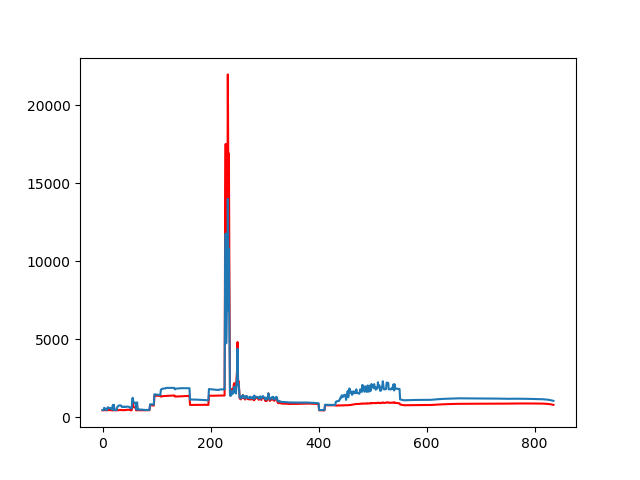

In [179]:
plt.figure()
plt.plot(range(len(xtrain)),error,"r")
plt.plot(range(len(xtrain)),val)

Usando el metodo de propagación con RN

In [15]:
def pesosAleatorios(L_in, L_out):
    
    e_ini = 0.12
    pesos = np.random.uniform(-e_ini,e_ini,size=(L_out, L_in+1))
    return pesos

In [16]:
theta1 = pesosAleatorios(6,5)
theta2 = pesosAleatorios(5,4)

In [18]:
def propagacion (x,th):
    a = []
    unos = np.full((1728,1),1)
    for i in range(len(x)):
        z = np.dot(x[i],np.transpose(th))
        a.append(sigmoide(z))

    return np.append(unos,a, axis = 1)

In [19]:
data, y = load_data('car.csv')
y, label = pd.factorize(y)
for i in range(data.shape[1]):
    data[:,i], labels= pd.factorize(data[:,i])
data = data.astype('float64')
y = y.astype('float64')
y = y.reshape(1728,1)


f = propagacion(x,theta1)
f2 = propagacion(f,theta2)

In [20]:
f = np.copy(f2[:,1:])

In [21]:
testeo(y,f)

(59, 3.4143518518518516)

Utilizando RN con retropropagación.

In [24]:
def backprop (params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, reg ):

    #Obtenemos theta1 y theta2
    theta1 = np.reshape(params_rn [:num_ocultas * (num_entradas + 1)],
    (num_ocultas, (num_entradas + 1) ) )
    theta2 = np.reshape(params_rn [num_ocultas * (num_entradas + 1):],
    ( num_etiquetas, (num_ocultas + 1) ) )
    
    #Añadimos una columna de unos a las X
    unos = np.ones([X.shape[0],1])
    _X = np.concatenate((unos,X),axis=1)    
    
    #Hallamos la hipótesis para las theta dadas, esto es necesario para el calculo del coste
    h = hipotesis(_X,theta1,theta2).T

    #Calculamos el coste con regularización
    coste = coste_Reg(h, Y, theta1, theta2, num_etiquetas, reg)
    grad = retro_propagacion(_X, Y, theta1, theta2, reg, num_etiquetas)

    return coste, grad

In [25]:
def coste_NR(h,Y,num_etiquetas):
    
    coste=0
    m = Y.shape[0]
    
    for i in range(num_etiquetas):
       
        _Y = (Y==i+1)*1
        coste += sum(-_Y*(np.log(h[i])) - (1-_Y)*(np.log(1-h[i])))
        
    return coste/m

In [26]:
def coste_Reg(h, Y, theta1, theta2, num_etiquetas, reg):
    
    m = Y.shape[0]
    theta1[0] = 0.0
    theta2[0] = 0.0
    
    coste = coste_NR(h,Y,num_etiquetas)
    coste += (sum(sum(theta1**2)) + sum(sum(theta2**2))) * (reg/m*2)
    
        
    return coste

In [27]:
def derivada_sig(Z):
    
    return sigmoide(Z)*(1-sigmoide(Z))
        
        
def hipotesis(X,theta1,theta2):
    
    #Capa primera - Capa oculta
    a_1 = sigmoide(X.dot(theta1.T))
    unos = np.ones([a_1.shape[0],1])
    
    #Capa oculta - Capa salida
    a_1 = np.concatenate((unos,a_1),axis=1)
    a_2 = sigmoide(a_1.dot(theta2.T))
    
    return a_2

In [28]:
def retro_propagacion(X, Y, theta1, theta2, reg, num_etiquetas):
        
    y = np.zeros((Y.shape[0],num_etiquetas))
    m = Y.shape[0]
    
    for i in range (num_etiquetas):

        y[i, Y[i]-1] = 1 
        
     #Capa primera - Capa oculta
    a_1 = sigmoide(X.dot(theta1.T))
    unos = np.ones([a_1.shape[0],1])
    
    #Capa oculta - Capa salida
    a_2 = np.concatenate((unos,a_1),axis=1)
    a_3 = sigmoide(a_2.dot(theta2.T))
    
    
    sigma3 = a_3 - y
    sigma2 = sigma3.dot(theta2)[:,1:]
    sigma2 = sigma2 * derivada_sig(X.dot(theta1.T))
    delta1 = sigma2.T.dot(X)
    delta2 = sigma3.T.dot(a_2)

    grad1 = delta1/m
    grad2 = delta2/m
    
    theta1[:,1]=0
    theta2[:,1]=0
    grad1 = grad1+(reg/m)*theta1
    grad2 = grad2+(reg/m)*theta2
    
    #Devolvemos el gradiente como una sola linea    
    return np.concatenate((np.ravel(grad1),np.ravel(grad2)))

In [29]:
def aprendizajeRN(X, Y, params, num_entradas, num_ocultas, num_etiquetas, lamb):
    
    
    m = Y.shape[0]
    
    #Función que entrena la red neuronal
    fmin = opt.minimize(fun=backprop, x0=params, 
                        args=(num_entradas, num_ocultas, num_etiquetas, X, Y, lamb),
                        method='TNC', jac=True, options={'maxiter':32})
    
    #Obtenemos las theta del entrenamiento
    theta1 = np.reshape(fmin.x [:num_ocultas * (num_entradas + 1)],
    (num_ocultas, (num_entradas + 1) ) )
    theta2 = np.reshape(fmin.x [num_ocultas * (num_entradas + 1):],
    ( num_etiquetas, (num_ocultas + 1) ) )
    
    unos = np.ones([X.shape[0],1])
    _X = np.concatenate((unos,X),axis=1)
    
    #Comprobamos la fidelidad del entrenamiento con los casos de prueba
    res = hipotesis(_X,theta1,theta2)
    
    result = np.argmax(res,axis=1) 
    
    result = (result == (Y))*1
    
    porcentaje = (sum(result)*100)/m

    print("Término de regularización: ", lamb)
    print("Númeo de iteraciones: ", 33)
    print("Porcentaje de acierto: ", porcentaje)

A partir de 33 iteraciones el valor alcanza su máximo por otro lado hemos comprobado que el valor de regularización afecta de manera anecdótica.

In [36]:
theta1 = pesosAleatorios(6,3)
theta2 = pesosAleatorios(3,4)

In [37]:
th1_opt = theta1
th2_opt = theta2

In [38]:
data, y = load_data('car.csv')
y, label = pd.factorize(y)
for i in range(data.shape[1]):
    data[:,i], labels= pd.factorize(data[:,i])
data = data.astype('float64')
y = y.astype('float64')
y = y.reshape(1728,1)
y = np.array(y.T)[0]



    # Theta1 e s de dimensión 5 x 7
    # Theta2 e s de dimensión 4 x 6
    
    
theta_vec = np.concatenate((np.ravel(theta1),np.ravel(theta2)))
num_entradas = theta1.shape[1]-1
num_ocultas = theta1.shape[0]
aprendizajeRN(data.astype('int'),y.astype('int'),theta_vec,num_entradas, num_ocultas, 4, 100)

Término de regularización:  100
Númeo de iteraciones:  33
Porcentaje de acierto:  70.02314814814815


In [ ]:
plot.figure